In [1]:
import sys
import LangtjernWeather as lw
import numpy as np
import datetime
import pandas as pd
import getpass
import matplotlib
import matplotlib.pyplot as plt
import getpass
import itertools as IT
from itertools import compress
from matplotlib import rc
import shutil
import os
import re
import pickle
import pylab
import statsmodels.api as sm
from patsy import dmatrices
import instantiationFimex as fimex
from subprocess import Popen, PIPE, CalledProcessError
import xarray as xr

#Setting matplotlib style
matplotlib.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None
rc('text', usetex=True)
rc('xtick', labelsize = 16)
rc('ytick', labelsize = 16)
rc('font', size = 16)
#login function
def login():
    username = input("Username: [JLG] ") #default username JLG
    if not username :
        username = "JLG"
    password = getpass.getpass('Password: ')
    return username, password

#Creating directories to store files. This will overwrite if the directory already exists
def create_dir(dir_name) :
    if not os.path.exists(dir_name) :
        os.makedirs(dir_name)
    else :
        shutil.rmtree(dir_name)
        os.makedirs(dir_name)
#Helper function for plotting
def plot_df(df) :
    num_cols = len(df.columns)
    fig, axes = plt.subplots(nrows = num_cols, ncols = 1, figsize = (20, num_cols * 5))
    for name,ax_h in zip(df.columns, axes) :
        plt.sca(ax_h)
        plt.plot(df.index,df[name])
        #df[name].plot(ax = ax_h)
        ax_h.set_ylabel(name)
    return fig

def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

#Sanity check
print("Using python version:")
print(sys.version)
print("Paths to python libraries:")
print(sys.path)

#Creating directory to save results
result_dir = './results/'
create_dir(result_dir)    

Using python version:
3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
Paths to python libraries:
['', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python36.zip', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages/IPython/extensions', '/home/jose-luis/.ipython']


# Creating data files for GOTM ∕ FABM
## Credentials for Aquamonitor

In [2]:
username,password = login()

#Folder where the downloaded data will be saved
root = "./DownloadedData/"
create_dir(root)

Username: [JLG]  
Password:  ··············


## Defining period to download
This should be the same as in the "Catchment_and_weather" notebook

In [3]:
now = pd.to_datetime('today').strftime('%Y-%m-%d')
#datesToGet = '2019-01-01/{}'.format(now)
datesToGet = '2010-01-01/{}'.format(now)
start = datesToGet.split('/')

finish = pd.datetime.strptime(start[1],'%Y-%m-%d')
start = pd.datetime.strptime(start[0],'%Y-%m-%d')

# finish_dt = pd.datetime.strftime(finish,'%Y-%m-%d')
# start_dt = pd.datetime.strftime(start,'%Y-%m-%d')
# display(finish)

## Downloading meteo data measured locally at Langtjern

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4d9178e48>,
      dtype=object)

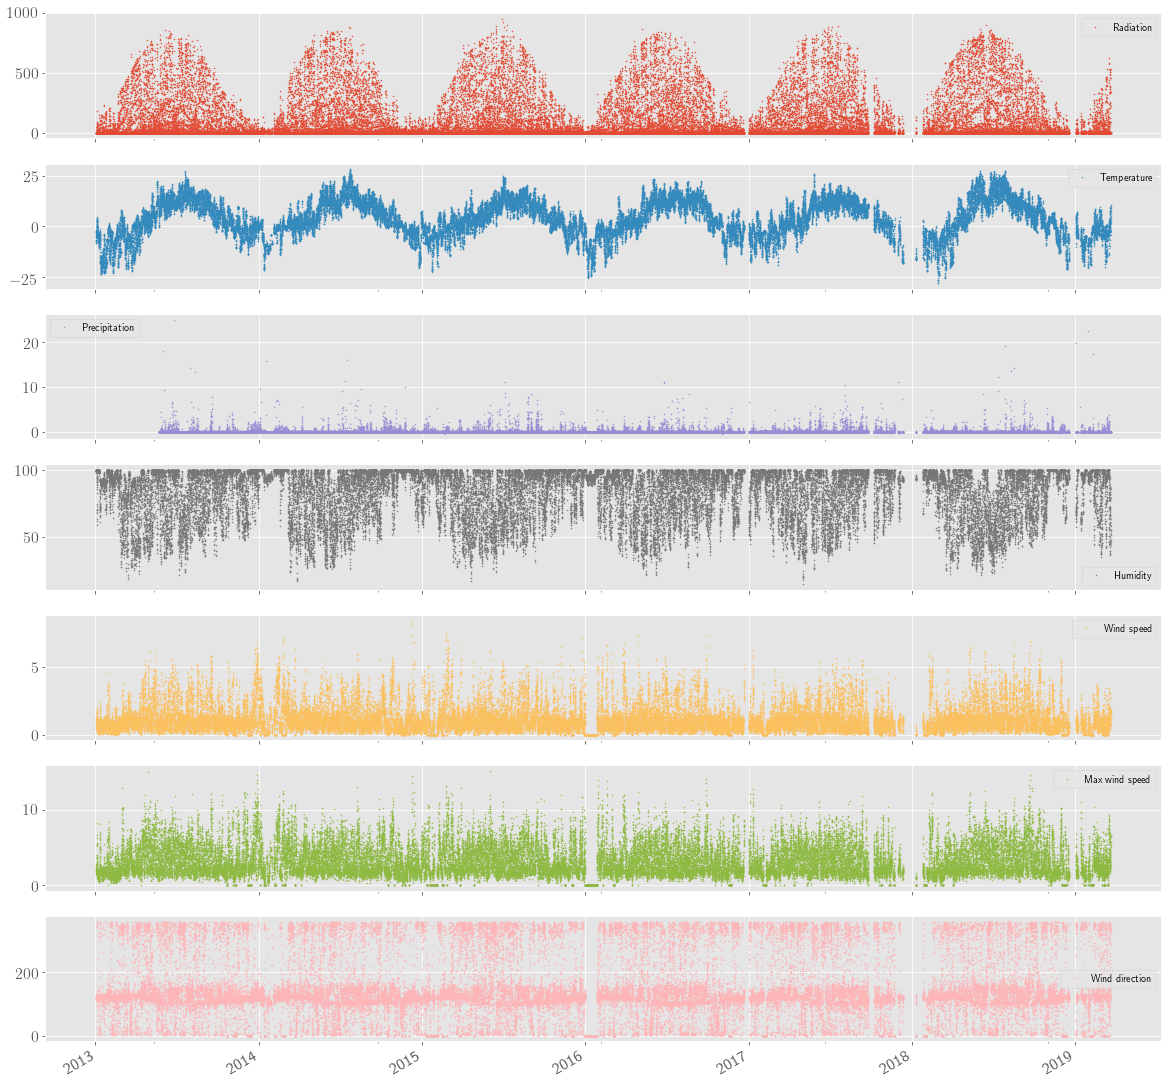

In [4]:
lake = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           62040,
                           'Air')
lake.drop(['ProjectId','ProjectName','StationId','StationCode','StationName','SampleDate_dato','SampleDate_tid'],
         inplace=True, axis=1)
lake.columns = lake.columns.str.strip()
lake.rename(columns={'Lufttemperatur_°C': 'Temperature',
                     'Globalstråling_W/m2' : 'Radiation',
                     'Nedbør_mm' : 'Precipitation',
                     'Relativ luftfuktighet_%': 'Humidity',
                      'Vindhastighet_m/s' : 'Wind speed',
                     'Vindhastighet (maks)_m/s' : 'Max wind speed',
                     'Vindretning_°' : 'Wind direction'                    
                    },
            inplace=True)

#display(lake)
lake.plot(subplots=True,figsize=(20,3*lake.shape[1]),
          marker='.',
          markersize=1,
          linestyle='None')

## Using data from nearby stations to patch time series

In [5]:
filename = 'metno.pickle'
with open(filename, "rb") as f:
    meta,data = pickle.load(f) 

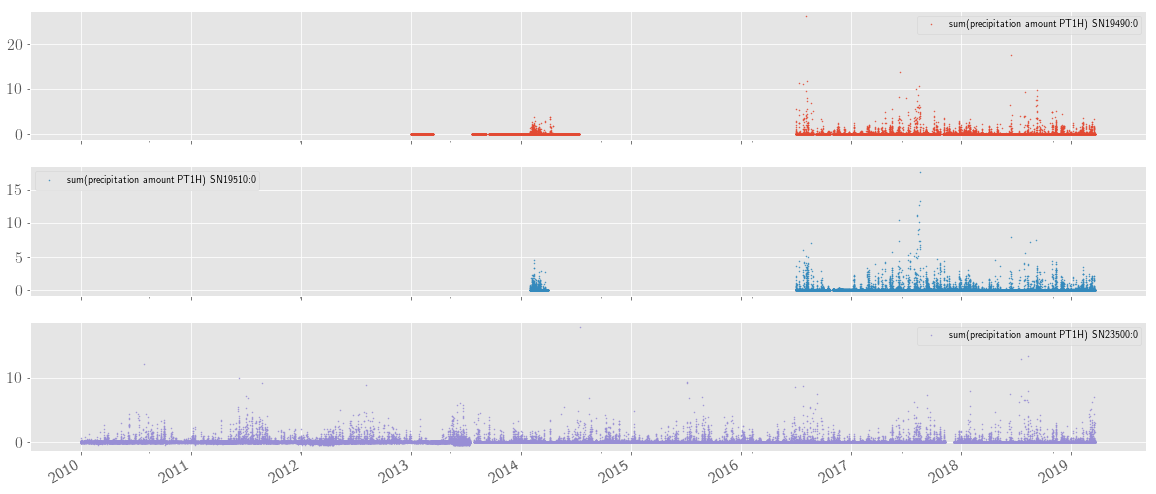

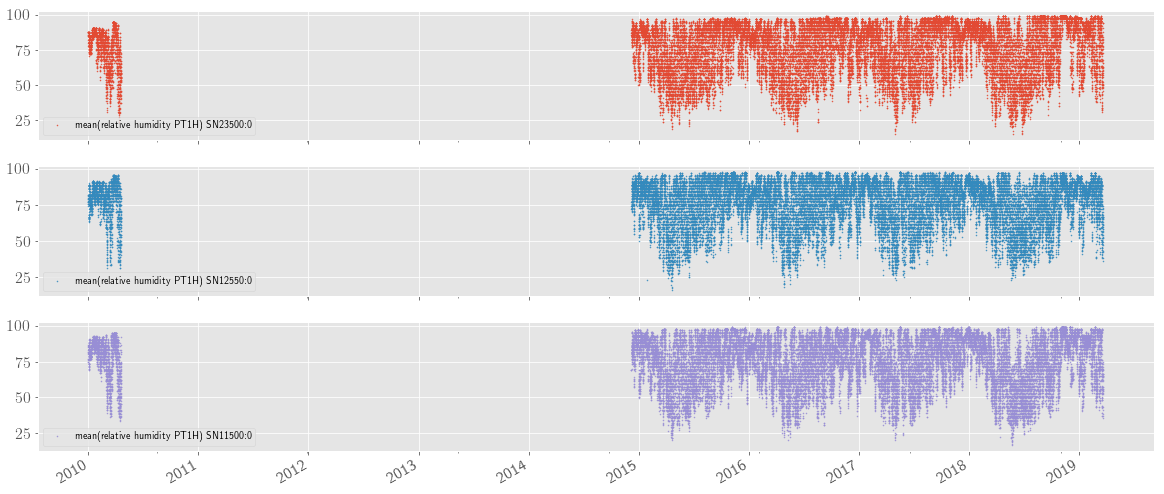

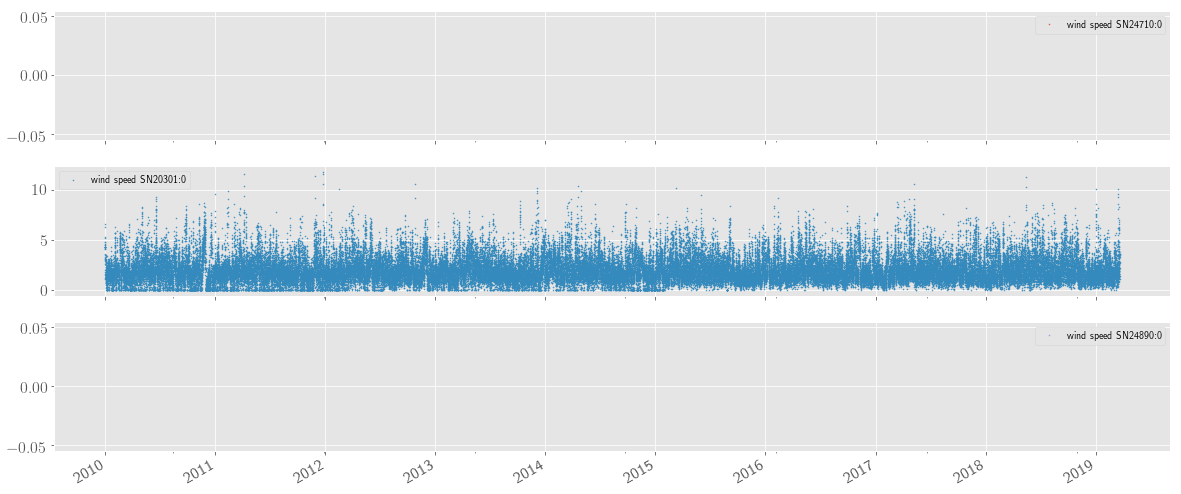

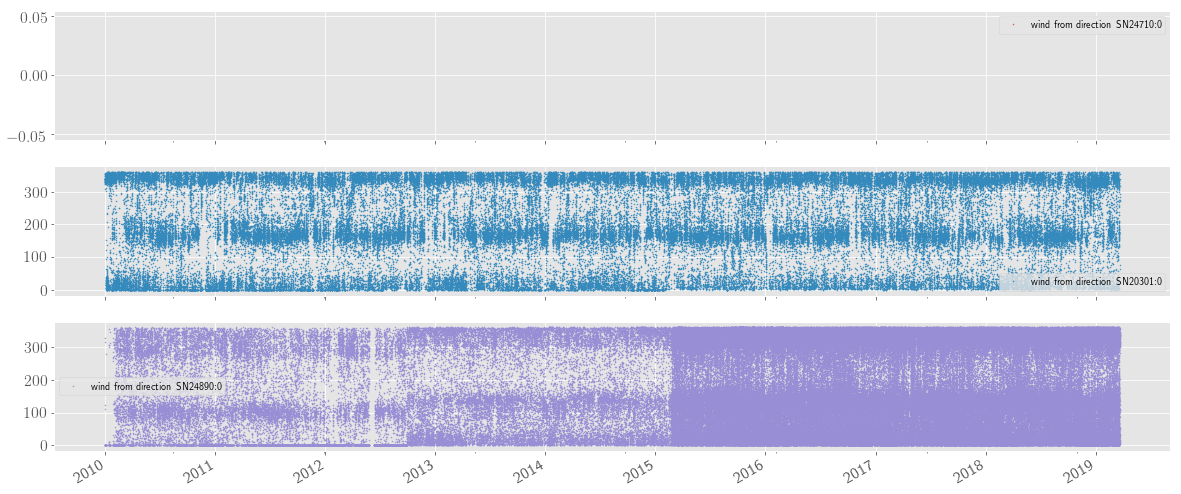

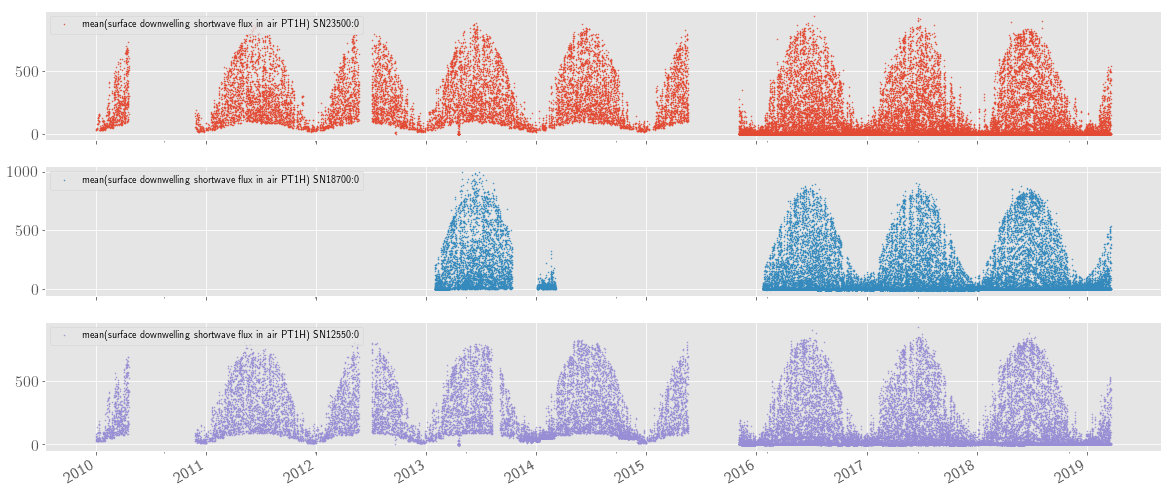

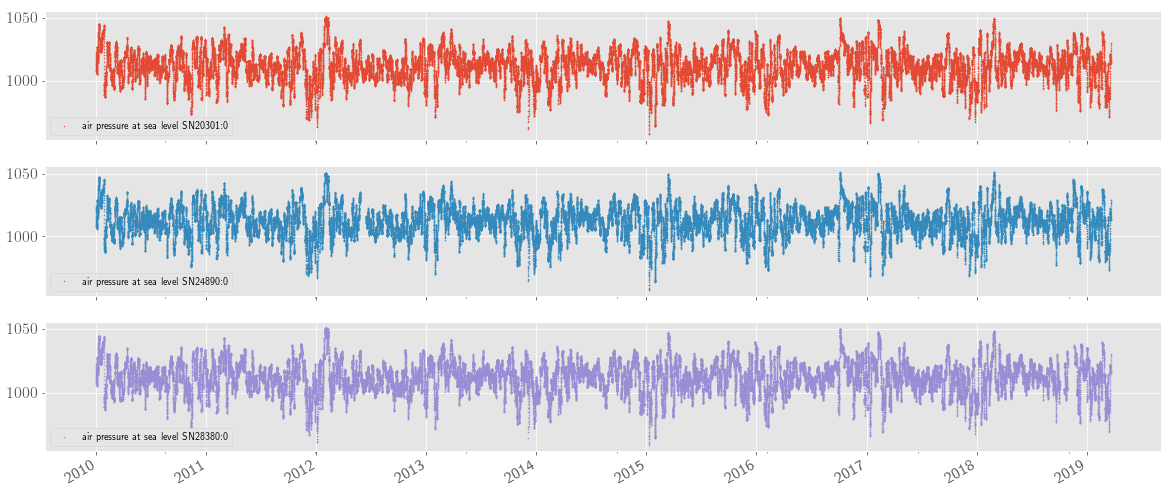

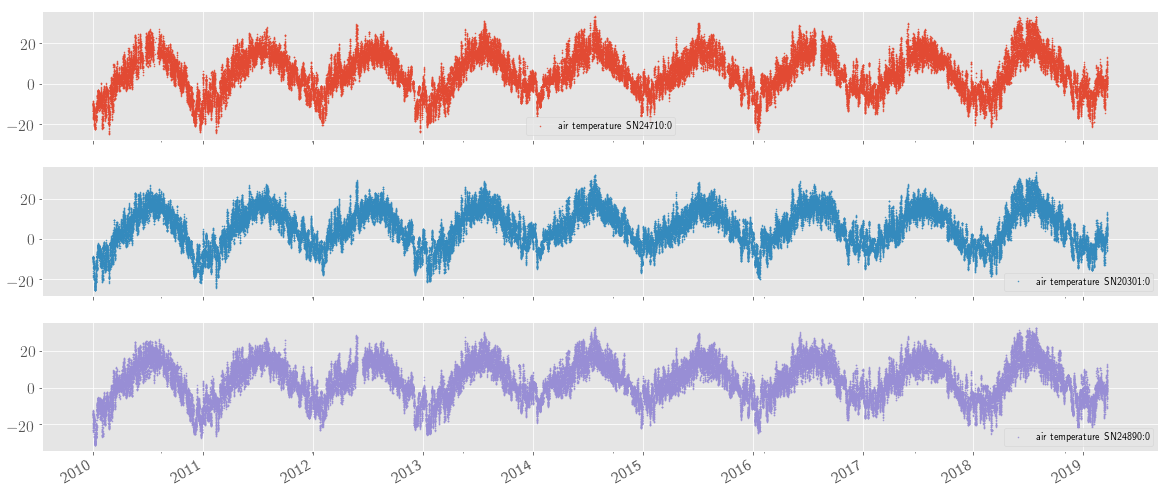

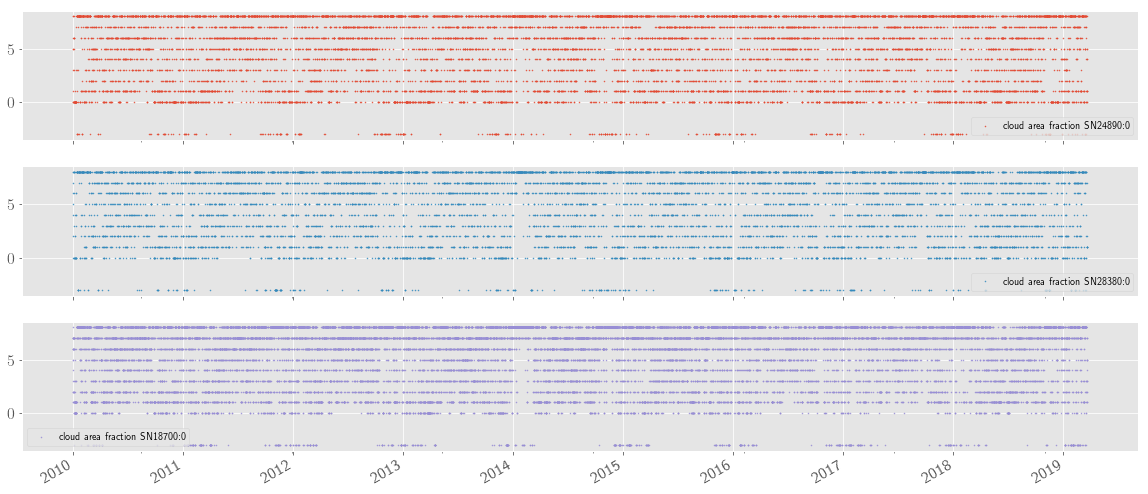

In [6]:
def plotVar(variable):
    data[variable].plot(subplots=True,
                           figsize=(20,3*len(data[variable].columns)),
                           marker='.',
                           markersize=1,                           
                           linestyle='None'
                       )    
for key,df in data.items():
    df.columns = df.columns.str.strip().str.replace('_',' ')
    plotVar(key)

### Patching precipitation
Patching precipitation from nearby stations is a silly endeavor. Instead we are getting daily data from when there are missing data and distributing it evenly during the day. We extract the precipition from metno's gridded dataset

In [7]:
# display(lake.columns)
startDf = lake['Precipitation'].index[0]
endDf = lake['Precipitation'].index[-1]
lake['Precipitation'][lake.Precipitation < 0.0] = 0.0

predictors = data['precipitation']
predictors.columns = ['a','b','c']
precipitation = pd.concat([lake['Precipitation'].to_frame(),predictors],axis=1, join='inner')
precipitation.dropna(inplace=True)
y, X = dmatrices('Precipitation ~ 0 + a + b + c', data=precipitation)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Precipitation   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     1431.
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:50:32   Log-Likelihood:                -16168.
No. Observations:               21129   AIC:                         3.234e+04
Df Residuals:                   21126   BIC:                         3.237e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a              0.1397      0.009     15.266      0.000       0.122       0.158
b              0.1993      0.010     20.086      0.000       0.180       0.219
c              0.3211      0.009     35.742      0.000       0.303       0.339
==============================================================================
Omnibus:                    43450.816   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        243177316.002
Skew:                          17.195   Prob(JB):                         0.00
Kurtosis:                     527.440   Cond. No.                         2.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It makes no sense to patch hourly precipitation with precipitation from nearby stations. We will instead use data from from the nordic gridded dataset. 

#### Showing extracted gridded precipitation at Langtjern

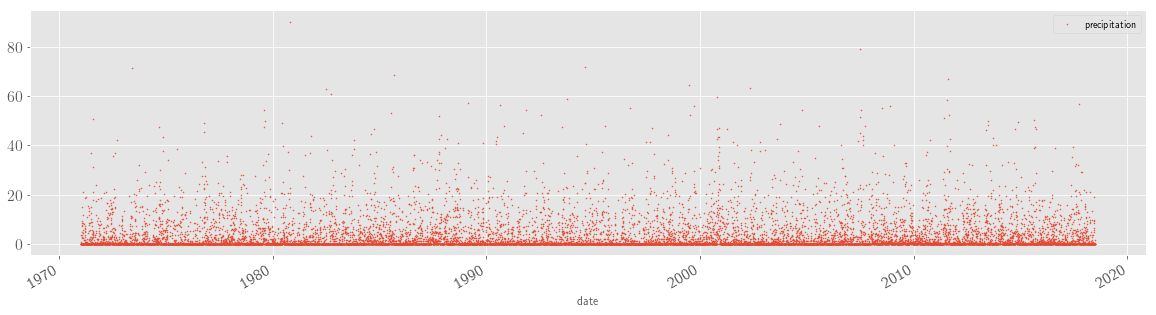

In [8]:
nc_file = precip = './precip.nc'
nc_data = xr.open_dataset(nc_file)
precipitation = nc_data.RR.isel(x=0,y=0)
precip_time = nc_data.time

dailyPrecip = pd.DataFrame({'date':precip_time, 'precipitation': precipitation})
dailyPrecip.set_index('date', inplace = True)
dailyPrecip.plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

#### Actually patching

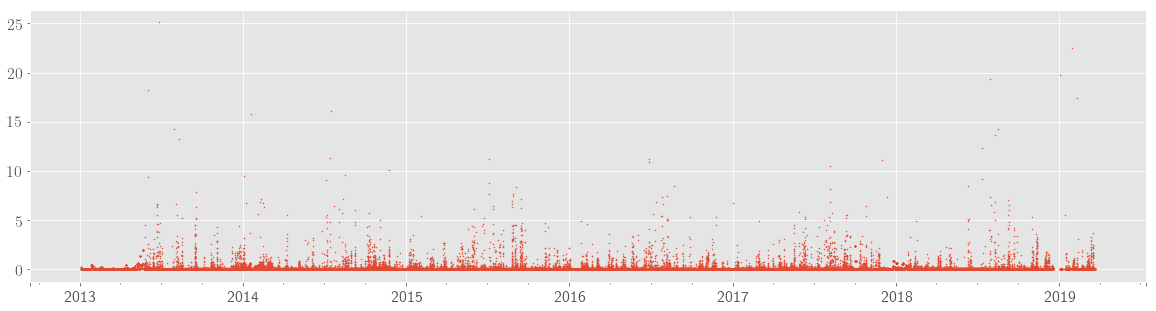

In [9]:
filledPrecip = pd.date_range(startDf, endDf, freq='H')
filledPrecip = pd.DataFrame(index = filledPrecip)
filledPrecip = pd.merge(filledPrecip,lake['Precipitation'].to_frame(),left_index = True, right_index = True, how = 'left')   

def hourlyPrecip(date):
    currentDay = pd.Timestamp(date.year,date.month,date.day,18);
    nextDay = currentDay + datetime.timedelta(days=1)
    if currentDay in dailyPrecip.index and date.hour <= 18:
        return dailyPrecip.loc[currentDay,'precipitation']/24
    elif date.hour > 18 and nextDay in dailyPrecip.index:
            return dailyPrecip.loc[nextDay,'precipitation']/24
    else:
        return np.nan

      
    
date = pd.Timestamp(2015,1,1)
filledPrecip['dummy']=filledPrecip.index
filledPrecip['dummy'] = filledPrecip['dummy'].apply(hourlyPrecip)

filledPrecip["Precipitation"] = filledPrecip.apply(lambda  row: row.dummy if np.isnan(row.Precipitation) else row.Precipitation, axis=1)


filledPrecip['Precipitation'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

## Patching temperature

In [10]:
startDf = lake['Temperature'].index[0]
endDf = lake['Temperature'].index[-1]

#Radiation shouldn't be negative

predictors = data['air_temperature']
predictors.columns = ['a','b','c']
temperature = pd.concat([lake['Temperature'].to_frame(),predictors],axis=1, join='inner')
temperature.dropna(inplace=True)
y, X = dmatrices('Temperature ~ 0 + a + b + c', data=temperature)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                 2.861e+05
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:50:38   Log-Likelihood:            -1.0870e+05
No. Observations:               48940   AIC:                         2.174e+05
Df Residuals:                   48937   BIC:                         2.174e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a              0.3046      0.007     44.743      0.000       0.291       0.318
b              0.0664      0.005     12.640      0.000       0.056       0.077
c              0.4770      0.004    113.380      0.000       0.469       0.485
==============================================================================
Omnibus:                     2335.523   Durbin-Watson:                   0.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8553.136
Skew:                           0.040   Prob(JB):                         0.00
Kurtosis:                       5.046   Cond. No.                         16.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

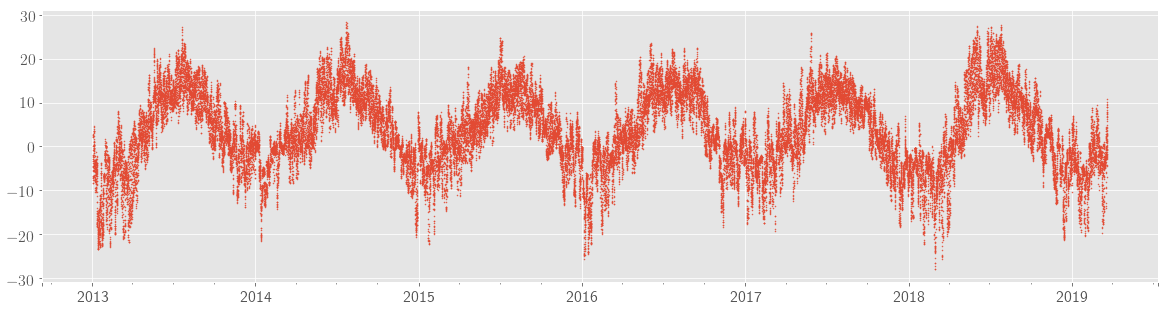

In [11]:
#Filling from nearby stations if available, using the model above
filledTemp = pd.date_range(startDf, endDf, freq='H')
filledTemp = pd.DataFrame(index = filledTemp)
filledTemp = pd.merge(filledTemp, lake['Temperature'].to_frame(),left_index = True, right_index = True, how = 'outer')   
filledTemp = pd.concat([filledTemp,data['air_temperature']], axis = 1, join_axes = [filledTemp.index])
#filledTemp = pd.merge(filledTemp, data['air_temperature'],left_index = True, right_index = True, how = 'inner') 

filledTemp['Temperature'] = filledTemp.apply(lambda row : np.float64(model.predict(row[['a','b','c']].values)) 
                                                   if np.isnan(row['Temperature']) and np.logical_not(np.isnan(row.values[1:]).any()) 
                                                   else row['Temperature'],
                                                   axis=1)
filledTemp['Temperature'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

#If there are still missing values, interpolate from existing values
#Should eventually add a sanity check but there are only 9 values that were not filled for this case
filledTemp['Temperature'].interpolate(method='time',inplace=True)

In [17]:
display(filledTemp.isnull().sum())

Temperature       0
a              2468
b                18
c                19
dtype: int64

### Getting inlet data

The data that were read are: Index(['CDOM', 'Temperature', 'gh'], dtype='object')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4d95f4ba8>,
      dtype=object)

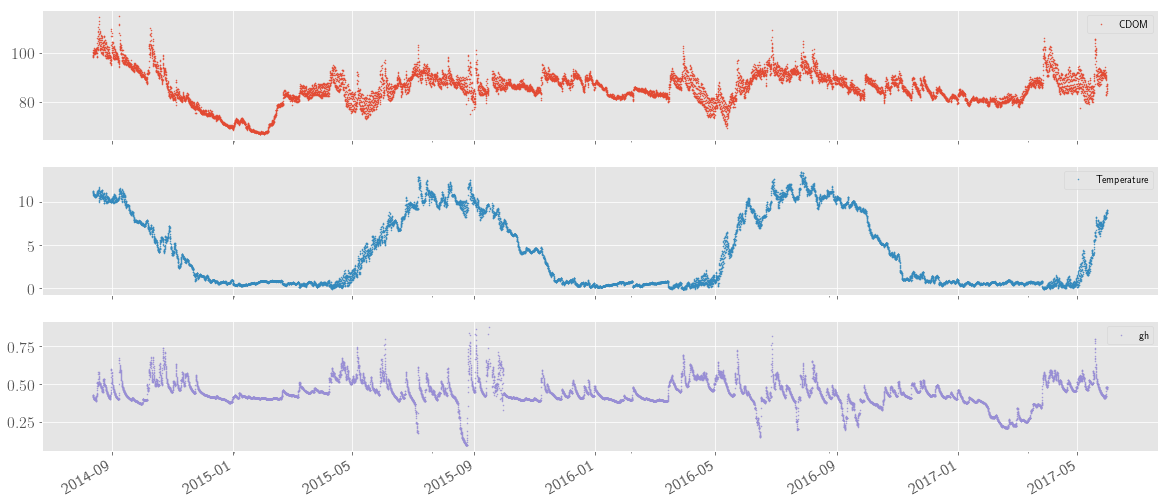

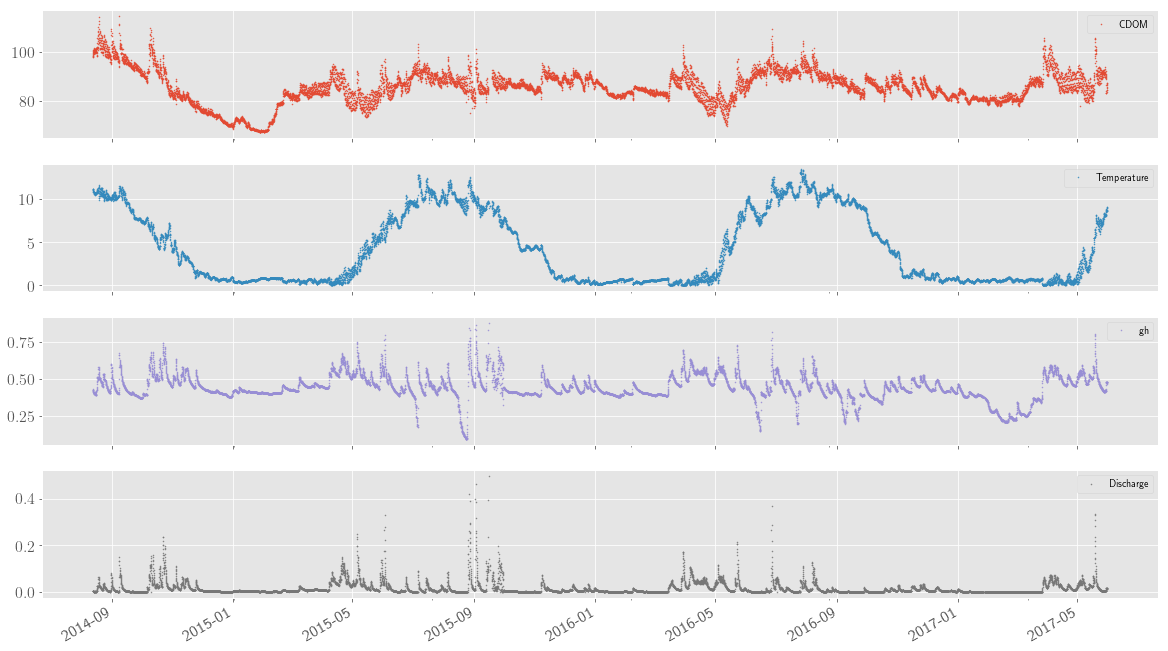

In [13]:
startDate = '2014-08-12 14:00:00'
endDate = '2017-05-31 00:00:00'

inlet = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           63098,
                           'Water')
inlet.drop(['Depth1', 'Depth2','ProjectId', 'ProjectName', 'StationId', 'StationCode',
             'StationName','SampleDate_dato', 'SampleDate_tid'], inplace=True, axis=1) 

inlet = inlet.rename(columns=lambda x: re.sub('[_/]',' ',x))
inlet = inlet.rename(columns=lambda x: re.sub('µ','u',x))
inlet =  inlet.rename(columns={'Vannstand m':'gh',u'CDOM ug L' : 'CDOM', 'Temperatur C': 'Temperature'})
print("The data that were read are: {}".format(inlet.columns))

inlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)

#Transforming stage into discharge
inletQ = lambda x : 2.391* np.power(x - 0.345, 2.5) if (x > 0.345) else 0.0001
inlet['Discharge'] = inlet.gh.apply(inletQ)
#inlet.Discharge *= (4.8 + 0.23) / 0.8
inlet.Temperature[inlet.Temperature < 0.0] = 0.0

inlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)


### Getting soil temperature


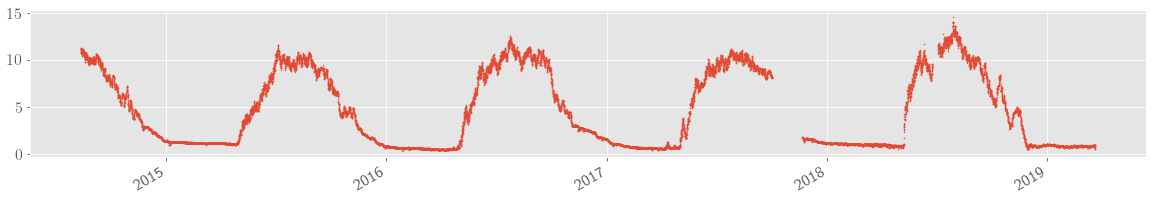

In [14]:
soilTemp = lw.getLangtjernData(username, password, root,
                               pd.datetime.strftime(start,'%Y/%m/%d'),
                               pd.datetime.strftime(finish,'%Y/%m/%d'),
                               63099,
                               'Water')
soilTemp = soilTemp.loc[[i == 0.15 for i in soilTemp['Depth1']],:]
soilTemp = soilTemp['Temperatur_C']
soilTemp = soilTemp.astype('float64')
soilTemp.plot(figsize=(20,3),marker='.',markersize=1,linestyle='')

### Combining all values together

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4f29e5dd8>,
      dtype=object)

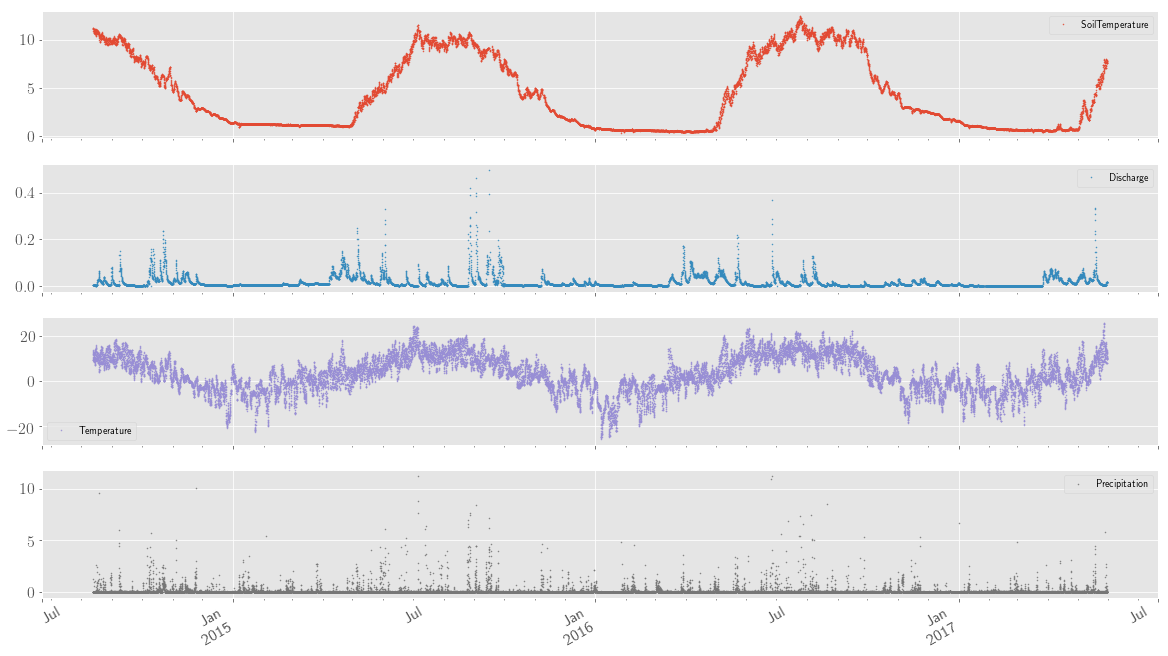

In [15]:
soilTemp = soilTemp.to_frame().rename(columns={'Temperatur_C' : 'SoilTemperature'})
allData = pd.concat( [soilTemp,
                      inlet['Discharge'].to_frame(),
                      filledTemp['Temperature'].to_frame(),
                      filledPrecip['Precipitation'].to_frame()                      
                     ] , axis=1, join='outer')
                     
allData[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)                     

### Getting daily values

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4d94c5b00>,
      dtype=object)

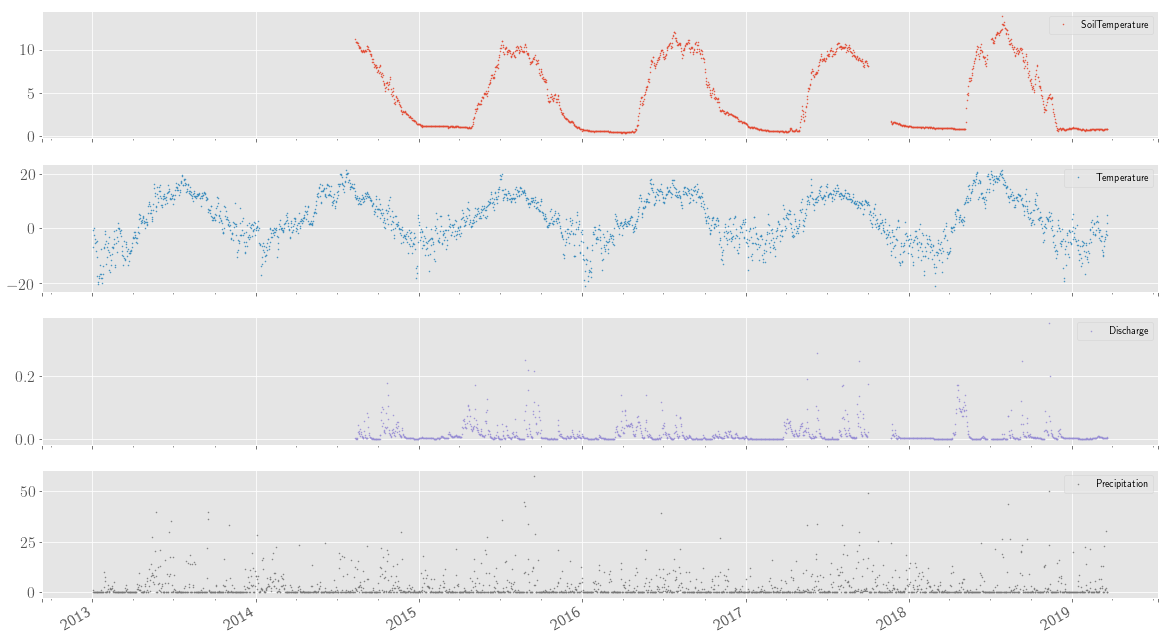

In [16]:
dailyMean = allData[['SoilTemperature','Temperature','Discharge']].resample('d').mean()
dailySum = allData['Precipitation'].resample('d').sum()

dailyData = pd.concat( [dailyMean,
                        dailySum.to_frame()                      
                       ] , 
                      axis=1, 
                      join='outer'
                     )
dailyData.plot(subplots=True,figsize=(20,3*len(dailyData.columns)),linestyle='None',marker='.',markersize=1)    